# Signal Comparison Minimal v2: Multi-Instrument Analysis

Compare Fourier series model with multiple instruments and notes.

**Mathematical Model:**
$$
f(t) = \sum_{n=0}^{\infty} A_n \cos\left(n\omega_0 t + \phi_n\right) + \sum_{n=0}^{\infty} \alpha_n A_n \cos\left(n\omega_0 t + \phi_n + \theta\right)
$$

**Analysis:**
- 3 Instruments: Acoustic Guitar, Classical Guitar, Electric Guitar
- 3 Notes per instrument: C, D, E
- Extract features and match Fourier model to each


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from pathlib import Path
import os

try:
    import librosa
except ImportError:
    print("Install librosa: pip install librosa")

plt.rcParams['figure.figsize'] = (16, 8)


In [2]:
def load_audio(file_path):
    """Load audio file (.m4a, .wav, .mp3, .csv)"""
    file_path = Path(file_path)
    
    # Try different path resolutions
    if file_path.is_absolute():
        resolved_path = file_path
    else:
        if file_path.exists():
            resolved_path = file_path
        elif (Path('ryan_files') / file_path).exists():
            resolved_path = Path('ryan_files') / file_path
        elif Path.cwd().name == 'ryan_files' and (Path('..') / file_path).exists():
            resolved_path = Path('..') / file_path
        else:
            alt_path = Path('ryan_files') / file_path
            if alt_path.exists():
                resolved_path = alt_path
            else:
                resolved_path = file_path
    
    resolved_path = resolved_path.resolve()
    
    if not resolved_path.exists():
        raise FileNotFoundError(f"Audio file not found: {file_path}\nTried: {resolved_path}")
    
    if resolved_path.suffix.lower() == '.csv':
        data = np.genfromtxt(resolved_path, delimiter=',', skip_header=1)
        time = data[:, 0] / 1000.0 if np.max(data[:, 0]) > 1000 else data[:, 0]
        amplitude = data[:, 1]
        if np.max(np.abs(amplitude)) > 0:
            amplitude = amplitude / np.max(np.abs(amplitude))
        sample_rate = 1.0 / (time[1] - time[0])
    else:
        amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)
        time = np.arange(len(amplitude)) / sample_rate
    
    return time, amplitude, sample_rate


In [3]:
def process_fourier_series(signal, sample_rate, time,
                           omega_0=None, num_harmonics=20,
                           A_n=None, phi_n=None, alpha_n=None, theta=0.0,
                           include_resonator=True):
    """
    Process signal using Fourier series model:
    f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)
    
    If include_resonator=False, only reconstructs the first series (no resonator effect).
    This is useful when extracting features from a signal that already has resonator effects.
    """
    fft_signal = rfft(signal)
    freqs = rfftfreq(len(signal), 1/sample_rate)
    magnitude = np.abs(fft_signal)
    phase = np.angle(fft_signal)
    
    if omega_0 is None:
        mask = (freqs >= 20) & (freqs <= 2000)
        if np.any(mask):
            peak_idx = np.argmax(magnitude[mask])
            omega_0 = 2 * np.pi * freqs[mask][peak_idx]
        else:
            omega_0 = 2 * np.pi * 261.63
    
    f0_hz = omega_0 / (2 * np.pi)
    
    def get_coeff(coeff, n, default):
        if coeff is None:
            return default(n) if callable(default) else default
        elif isinstance(coeff, (list, np.ndarray)):
            if n < len(coeff):
                return coeff[n]
            return 0.0
        elif callable(coeff):
            return coeff(n)
        else:
            return coeff
    
    processed = np.zeros_like(signal)
    use_extracted = (isinstance(A_n, (list, np.ndarray)) and 
                     isinstance(phi_n, (list, np.ndarray)) and
                     len(A_n) >= num_harmonics and len(phi_n) >= num_harmonics)
    
    for n in range(num_harmonics):
        if use_extracted:
            A = A_n[n]
            phi = phi_n[n]
        else:
            target_freq = n * f0_hz
            if target_freq <= freqs[-1]:
                idx = np.argmin(np.abs(freqs - target_freq))
                A_input = magnitude[idx] / len(signal)
                phi_input = phase[idx]
                A_coeff = get_coeff(A_n, n, lambda n: 1.0)
                phi_coeff = get_coeff(phi_n, n, lambda n: 0.0)
                A = A_input * A_coeff
                phi = phi_input + phi_coeff
            else:
                A = 0.0
                phi = 0.0
        
        # First series: A_n cos(nω₀t + φ_n)
        processed += A * np.cos(n * omega_0 * time + phi)
        
        # Second series: α_n A_n cos(nω₀t + φ_n + θ) - only if include_resonator=True
        if include_resonator:
            alpha = get_coeff(alpha_n, n, lambda n: 0.5)
            processed += alpha * A * np.cos(n * omega_0 * time + phi + theta)
    
    # Normalize
    if np.max(np.abs(processed)) > 0 and np.max(np.abs(signal)) > 0:
        rms_signal = np.sqrt(np.mean(signal**2))
        rms_processed = np.sqrt(np.mean(processed**2))
        if rms_processed > 0:
            processed = processed * (rms_signal / rms_processed)
        max_signal = np.max(np.abs(signal))
        max_processed = np.max(np.abs(processed))
        if max_processed > max_signal and max_processed > 0:
            processed = processed * (max_signal / max_processed)
    elif np.max(np.abs(processed)) > 0:
        processed = processed / np.max(np.abs(processed))
    
    return processed


In [4]:
# Configuration
NUM_HARMONICS = None  # Set to None to auto-detect from signal, or specify a number (e.g., 25)
THETA = np.pi / 4  # Phase shift (radians)
INCLUDE_RESONATOR = True  # Set to False to reconstruct only the base signal (first series)
                           # Set to True to add resonator effect (second series)

# Auto-detection parameters (used when NUM_HARMONICS is None)
HARMONIC_THRESHOLD = 0.01  # Minimum normalized magnitude to count as significant harmonic
MAX_HARMONICS = 70  # Maximum number of harmonics to detect
SASANDO_FREQ_MIN = 98  # Minimum frequency for sasando range (Hz)
SASANDO_FREQ_MAX = 1047  # Maximum frequency for sasando range (Hz)

# Define instruments and notes to process
INSTRUMENTS = ['acoustic guitar', 'classical guitar', 'electric guitar']
NOTES = ['C', 'D', 'E']  # 3 notes per instrument
SAMPLE_NUM = 1  # Use _1.m4a files (can change to 2, 3, etc.)

# Define alpha_n function (resonator response)
def alpha_n_func(n, estimated_f0):
    """Frequency-dependent scaling based on sasando range (98-1047 Hz)"""
    freq_hz = n * estimated_f0
    return 0.8 if 98 <= freq_hz <= 1047 else 0.2

print("Configuration:")
print(f"  Instruments: {INSTRUMENTS}")
print(f"  Notes: {NOTES}")
if NUM_HARMONICS is None:
    print(f"  Harmonics: Auto-detect (threshold={HARMONIC_THRESHOLD}, max={MAX_HARMONICS})")
    print(f"  Sasando frequency range: {SASANDO_FREQ_MIN}-{SASANDO_FREQ_MAX} Hz")
else:
    print(f"  Harmonics: {NUM_HARMONICS} (fixed)")
print(f"  Phase shift θ: {THETA:.4f} rad ({np.degrees(THETA):.1f}°)")
print(f"  Include resonator effect: {INCLUDE_RESONATOR}")
if not INCLUDE_RESONATOR:
    print("  → Reconstructing only base signal (first series) to match original")
else:
    print("  → Adding resonator effect (both series)")


Configuration:
  Instruments: ['acoustic guitar', 'classical guitar', 'electric guitar']
  Notes: ['C', 'D', 'E']
  Harmonics: Auto-detect (threshold=0.01, max=70)
  Sasando frequency range: 98-1047 Hz
  Phase shift θ: 0.7854 rad (45.0°)
  Include resonator effect: True
  → Adding resonator effect (both series)


## Process All Instruments and Notes


In [5]:
# Store results for all combinations
results = {}

for instrument in INSTRUMENTS:
    results[instrument] = {}
    
    for note in NOTES:
        # Construct file path (files are named like C_acoustic_1.m4a, not C_acoustic_guitar_1.m4a)
        instrument_short = instrument.split()[0]  # Get first word: "acoustic", "classical", "electric"
        filename = f"{note}_{instrument_short}_{SAMPLE_NUM}.m4a"
        file_path = f"Data/{instrument}/{filename}"
        
        print(f"\n{'='*80}")
        print(f"Processing: {instrument} - Note {note}")
        print(f"File: {file_path}")
        print('='*80)
        
        try:
            # Load audio
            time, amplitude_original, sample_rate = load_audio(file_path)
            print(f"  Loaded: {sample_rate:.1f} Hz, {time[-1]:.2f}s duration")
            
            # Extract features
            fft_original = rfft(amplitude_original)
            freqs_original = rfftfreq(len(amplitude_original), 1/sample_rate)
            magnitude_original = np.abs(fft_original)
            phase_original = np.angle(fft_original)
            
            # Estimate fundamental
            mask = (freqs_original >= 20) & (freqs_original <= 2000)
            if np.any(mask):
                peak_idx = np.argmax(magnitude_original[mask])
                estimated_f0 = freqs_original[mask][peak_idx]
                omega_0 = 2 * np.pi * estimated_f0
            else:
                estimated_f0 = 261.63
                omega_0 = 2 * np.pi * estimated_f0
            
            print(f"  Estimated fundamental: {estimated_f0:.2f} Hz")
            
            # Auto-detect number of harmonics if not specified
            if NUM_HARMONICS is None:
                # Strategy: Collect all significant harmonics up to:
                # 1. MAX_HARMONICS limit, OR
                # 2. Until we exceed SASANDO_FREQ_MAX
                max_magnitude = np.max(magnitude_original)
                significant_harmonics = []
                
                for n in range(1, MAX_HARMONICS + 1):  # Start from n=1 (skip DC)
                    target_freq = n * estimated_f0
                    
                    # Stop if frequency exceeds sasando range
                    if target_freq > SASANDO_FREQ_MAX:
                        break
                    
                    # Stop if frequency exceeds available FFT range
                    if target_freq > freqs_original[-1]:
                        break
                    
                    # Check if this harmonic is significant
                    idx = np.argmin(np.abs(freqs_original - target_freq))
                    normalized_mag = magnitude_original[idx] / max_magnitude if max_magnitude > 0 else 0
                    
                    if normalized_mag >= HARMONIC_THRESHOLD:
                        significant_harmonics.append(n)
                
                # Include DC component (n=0) and all detected harmonics
                num_harmonics_to_use = len(significant_harmonics) + 1  # +1 for DC
                max_detected = max(significant_harmonics) if significant_harmonics else 0
                max_freq = max_detected * estimated_f0 if max_detected > 0 else 0
                print(f"  Auto-detected {num_harmonics_to_use} harmonics (n=0 to n={max_detected})")
                print(f"  Frequency range: 0 to {max_freq:.1f} Hz (sasando range: {SASANDO_FREQ_MIN}-{SASANDO_FREQ_MAX} Hz)")
            else:
                num_harmonics_to_use = NUM_HARMONICS
            
            # Extract A_n and φ_n
            A_n_extracted = []
            phi_n_extracted = []
            
            for n in range(num_harmonics_to_use):
                target_freq = n * estimated_f0
                if target_freq <= freqs_original[-1]:
                    idx = np.argmin(np.abs(freqs_original - target_freq))
                    if n == 0:
                        A_n = magnitude_original[idx] / len(amplitude_original)
                    else:
                        A_n = 2 * magnitude_original[idx] / len(amplitude_original)
                    phi_n = phase_original[idx]
                    A_n_extracted.append(A_n)
                    phi_n_extracted.append(phi_n)
                else:
                    A_n_extracted.append(0.0)
                    phi_n_extracted.append(0.0)
            
            # Create alpha_n function with this f0
            def alpha_n_with_f0(n):
                return alpha_n_func(n, estimated_f0)
            
            # Process with Fourier model
            A_n_array = np.array(A_n_extracted)
            phi_n_array = np.array(phi_n_extracted)
            
            amplitude_fourier = process_fourier_series(
                amplitude_original, sample_rate, time,
                omega_0=omega_0,
                num_harmonics=num_harmonics_to_use,
                A_n=A_n_array,
                phi_n=phi_n_array,
                alpha_n=alpha_n_with_f0,
                theta=THETA,
                include_resonator=INCLUDE_RESONATOR
            )
            
            # Store results
            results[instrument][note] = {
                'time': time,
                'amplitude_original': amplitude_original,
                'amplitude_fourier': amplitude_fourier,
                'sample_rate': sample_rate,
                'f0': estimated_f0,
                'omega_0': omega_0,
                'A_n': A_n_extracted,
                'phi_n': phi_n_extracted,
                'file_path': file_path
            }
            
            # Print extracted features
            print(f"\n  Extracted harmonics:")
            num_to_print = min(10, num_harmonics_to_use)  # Print first 10 or all if fewer
            for n in range(num_to_print):
                freq = n * estimated_f0
                print(f"    n={n}: f={freq:.2f} Hz, A_n={A_n_extracted[n]:.6f}, φ_n={phi_n_extracted[n]:.4f} rad")
            if num_harmonics_to_use > num_to_print:
                print(f"    ... ({num_harmonics_to_use - num_to_print} more harmonics)")
            
            # Diagnostics
            max_orig = np.max(np.abs(amplitude_original))
            max_fourier = np.max(np.abs(amplitude_fourier))
            rms_orig = np.sqrt(np.mean(amplitude_original**2))
            rms_fourier = np.sqrt(np.mean(amplitude_fourier**2))
            print(f"\n  Amplitude comparison:")
            print(f"    Original - Max: {max_orig:.6f}, RMS: {rms_orig:.6f}")
            print(f"    Fourier - Max: {max_fourier:.6f}, RMS: {rms_fourier:.6f}")
            print(f"    Ratio (Fourier/Original): {max_fourier/max_orig:.2f}")
            
            print(f"  ✓ Successfully processed")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results[instrument][note] = None

print(f"\n\n{'='*80}")
print(f"Processing complete!")
print(f"  Total: {len(INSTRUMENTS)} instruments × {len(NOTES)} notes = {len(INSTRUMENTS) * len(NOTES)} files")
print(f"{'='*80}")



Processing: acoustic guitar - Note C
File: Data/acoustic guitar/C_acoustic_1.m4a


/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_45521/2955513416.py:35: UserWarning: PySoundFile failed. Trying audioread instead.
  amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)
/Users/ryanle/Projects/Sasando-FFT/ryan_venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Loaded: 48000.0 Hz, 7.55s duration
  Estimated fundamental: 262.63 Hz
  Auto-detected 4 harmonics (n=0 to n=3)
  Frequency range: 0 to 787.9 Hz (sasando range: 98-1047 Hz)

  Extracted harmonics:
    n=0: f=0.00 Hz, A_n=0.000001, φ_n=0.0000 rad
    n=1: f=262.63 Hz, A_n=0.003185, φ_n=-2.2238 rad
    n=2: f=525.25 Hz, A_n=0.000326, φ_n=-2.3859 rad
    n=3: f=787.88 Hz, A_n=0.000168, φ_n=-0.3593 rad

  Amplitude comparison:
    Original - Max: 0.095612, RMS: 0.007780
    Fourier - Max: 0.011864, RMS: 0.007780
    Ratio (Fourier/Original): 0.12
  ✓ Successfully processed

Processing: acoustic guitar - Note D
File: Data/acoustic guitar/D_acoustic_1.m4a
  Loaded: 48000.0 Hz, 7.42s duration
  Estimated fundamental: 145.90 Hz
  Auto-detected 6 harmonics (n=0 to n=7)
  Frequency range: 0 to 1021.3 Hz (sasando range: 98-1047 Hz)

  Extracted harmonics:
    n=0: f=0.00 Hz, A_n=0.000000, φ_n=0.0000 rad
    n=1: f=145.90 Hz, A_n=0.005796, φ_n=-2.6936 rad
    n=2: f=291.81 Hz, A_n=0.000921, φ_n=2

/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_45521/2955513416.py:35: UserWarning: PySoundFile failed. Trying audioread instead.
  amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)
/Users/ryanle/Projects/Sasando-FFT/ryan_venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



  Extracted harmonics:
    n=0: f=0.00 Hz, A_n=0.000001, φ_n=3.1416 rad
    n=1: f=163.96 Hz, A_n=0.006620, φ_n=-0.9449 rad
    n=2: f=327.92 Hz, A_n=0.000652, φ_n=1.1051 rad
    n=3: f=491.88 Hz, A_n=0.000180, φ_n=-1.1718 rad

  Amplitude comparison:
    Original - Max: 0.072235, RMS: 0.009320
    Fourier - Max: 0.014456, RMS: 0.009320
    Ratio (Fourier/Original): 0.20
  ✓ Successfully processed

Processing: classical guitar - Note C
File: Data/classical guitar/C_classical_1.m4a
  Loaded: 48000.0 Hz, 7.68s duration
  Estimated fundamental: 131.14 Hz
  Auto-detected 7 harmonics (n=0 to n=6)
  Frequency range: 0 to 786.9 Hz (sasando range: 98-1047 Hz)

  Extracted harmonics:
    n=0: f=0.00 Hz, A_n=0.000001, φ_n=0.0000 rad
    n=1: f=131.14 Hz, A_n=0.023864, φ_n=2.3672 rad
    n=2: f=262.29 Hz, A_n=0.009990, φ_n=1.6944 rad
    n=3: f=393.43 Hz, A_n=0.007728, φ_n=-2.2550 rad
    n=4: f=524.57 Hz, A_n=0.000241, φ_n=-0.1830 rad
    n=5: f=655.71 Hz, A_n=0.000251, φ_n=-2.2346 rad
    n=6:

## Visualize Results: Amplitude vs. Time & Frequency


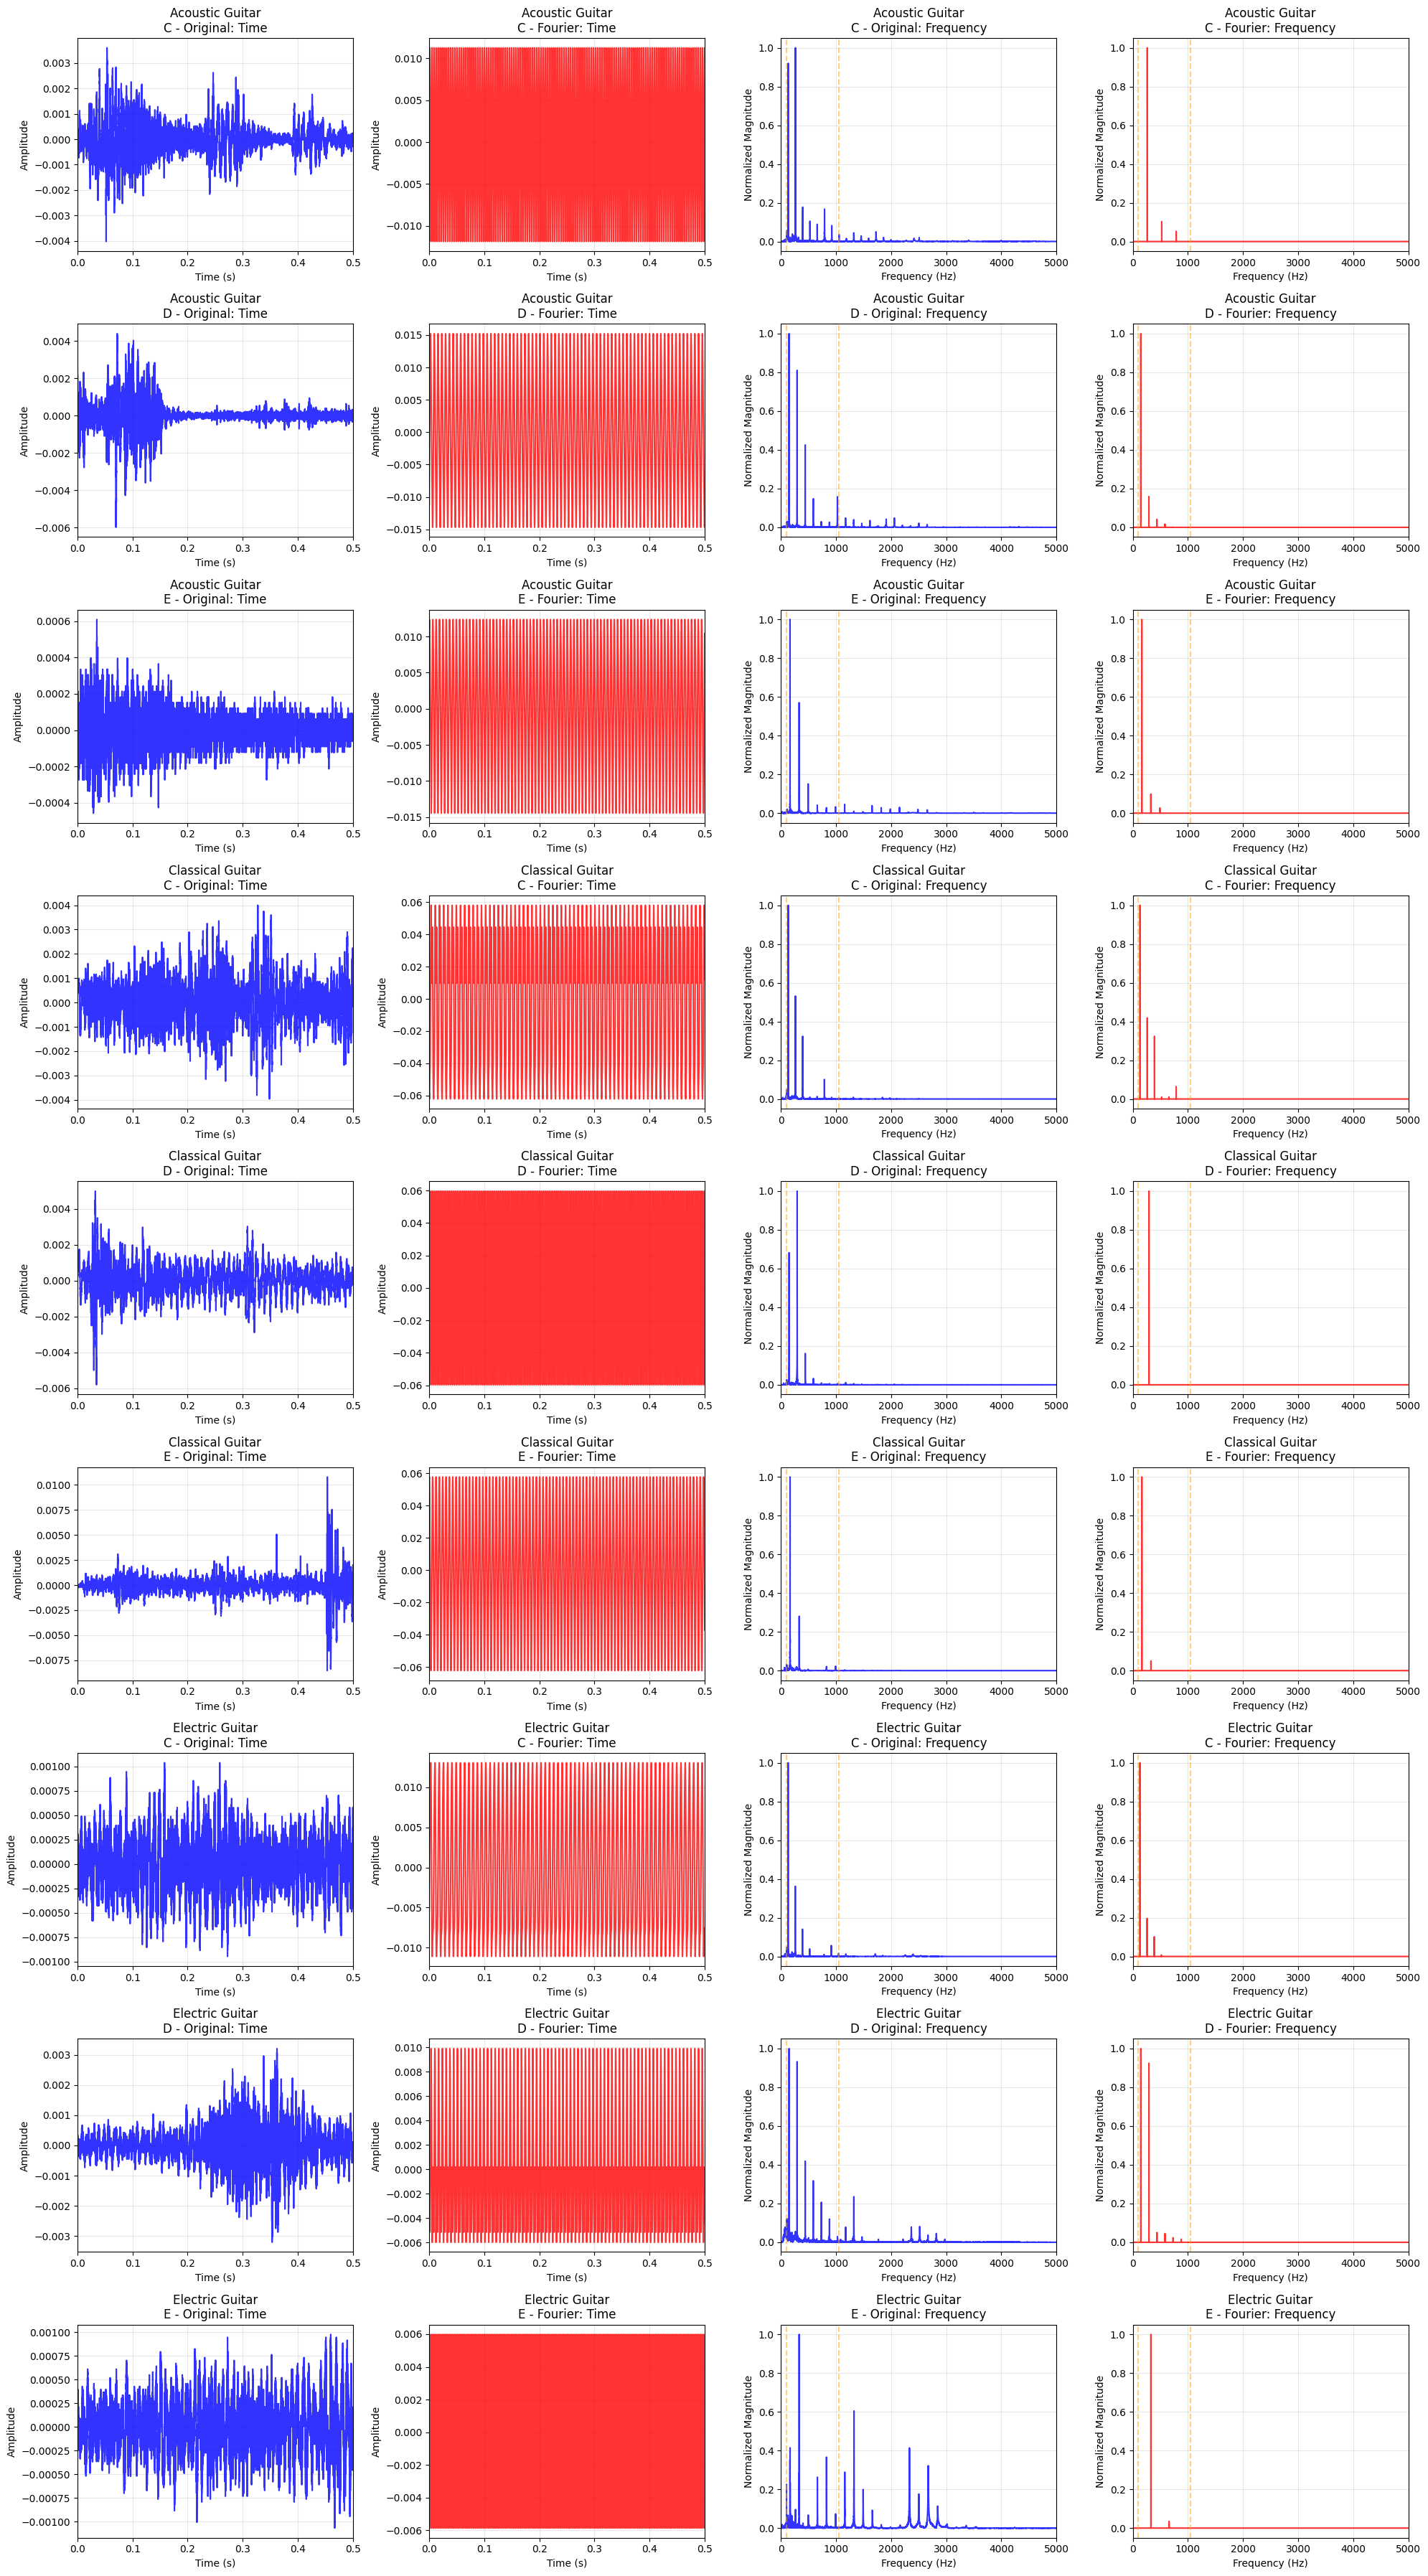

In [6]:
# Create comprehensive visualization for all instruments and notes
total_plots = len(INSTRUMENTS) * len(NOTES)
fig, axes = plt.subplots(total_plots, 4, figsize=(20, 4 * total_plots))

plot_idx = 0
for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        time = data['time']
        amp_orig = data['amplitude_original']
        amp_fourier = data['amplitude_fourier']
        sample_rate = data['sample_rate']
        
        # Compute FFT
        fft_orig = rfft(amp_orig)
        fft_fourier = rfft(amp_fourier)
        freqs = rfftfreq(len(amp_orig), 1/sample_rate)
        mag_orig = np.abs(fft_orig)
        mag_fourier = np.abs(fft_fourier)
        mag_orig_norm = mag_orig / np.max(mag_orig) if np.max(mag_orig) > 0 else mag_orig
        mag_fourier_norm = mag_fourier / np.max(mag_fourier) if np.max(mag_fourier) > 0 else mag_fourier
        
        # Time window
        t_window = min(0.5, time[-1])
        t_mask = time <= t_window
        freq_mask = freqs <= 5000
        
        # Plot 1: Original - Time
        ax = axes[plot_idx, 0]
        ax.plot(time[t_mask], amp_orig[t_mask], 'b-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'{instrument.title()}\n{note} - Original: Time')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Plot 2: Fourier - Time
        ax = axes[plot_idx, 1]
        ax.plot(time[t_mask], amp_fourier[t_mask], 'r-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'{instrument.title()}\n{note} - Fourier: Time')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Plot 3: Original - Frequency
        ax = axes[plot_idx, 2]
        ax.plot(freqs[freq_mask], mag_orig_norm[freq_mask], 'b-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'{instrument.title()}\n{note} - Original: Frequency')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5)
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
        
        # Plot 4: Fourier - Frequency
        ax = axes[plot_idx, 3]
        ax.plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, alpha=0.8)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'{instrument.title()}\n{note} - Fourier: Frequency')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5)
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
        
        plot_idx += 1

plt.tight_layout()
plt.show()


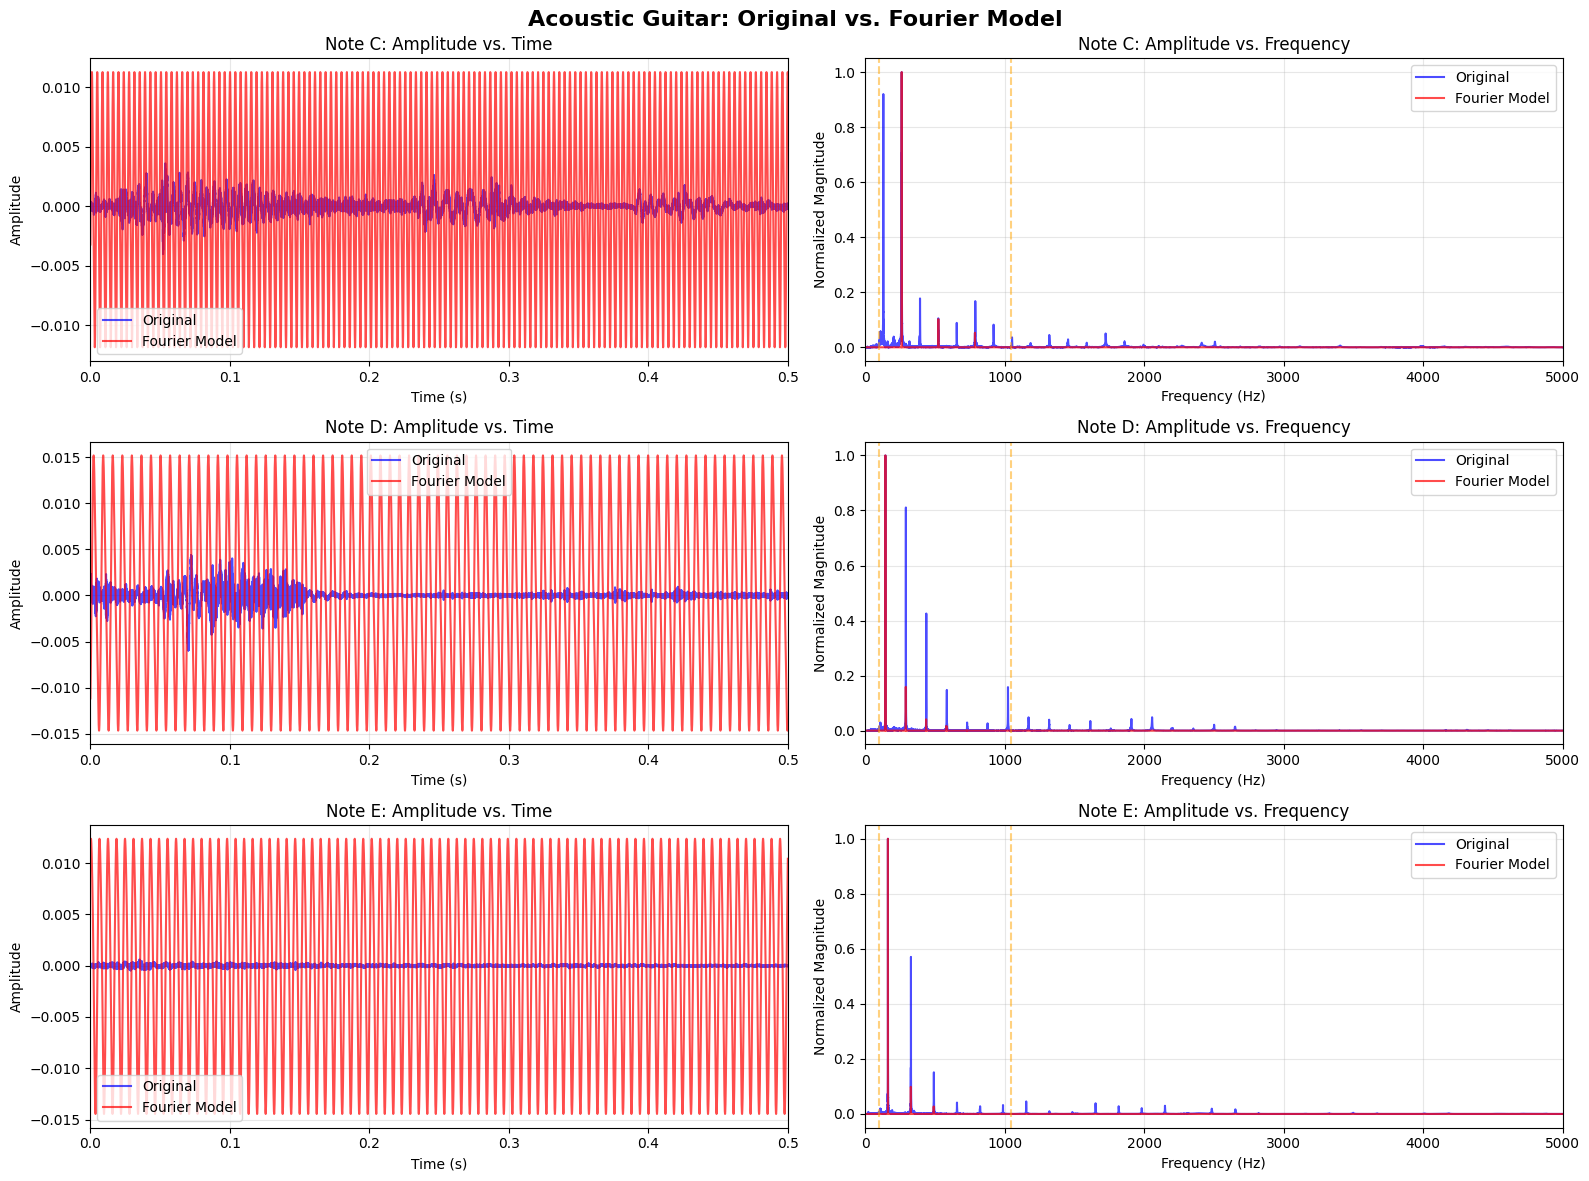

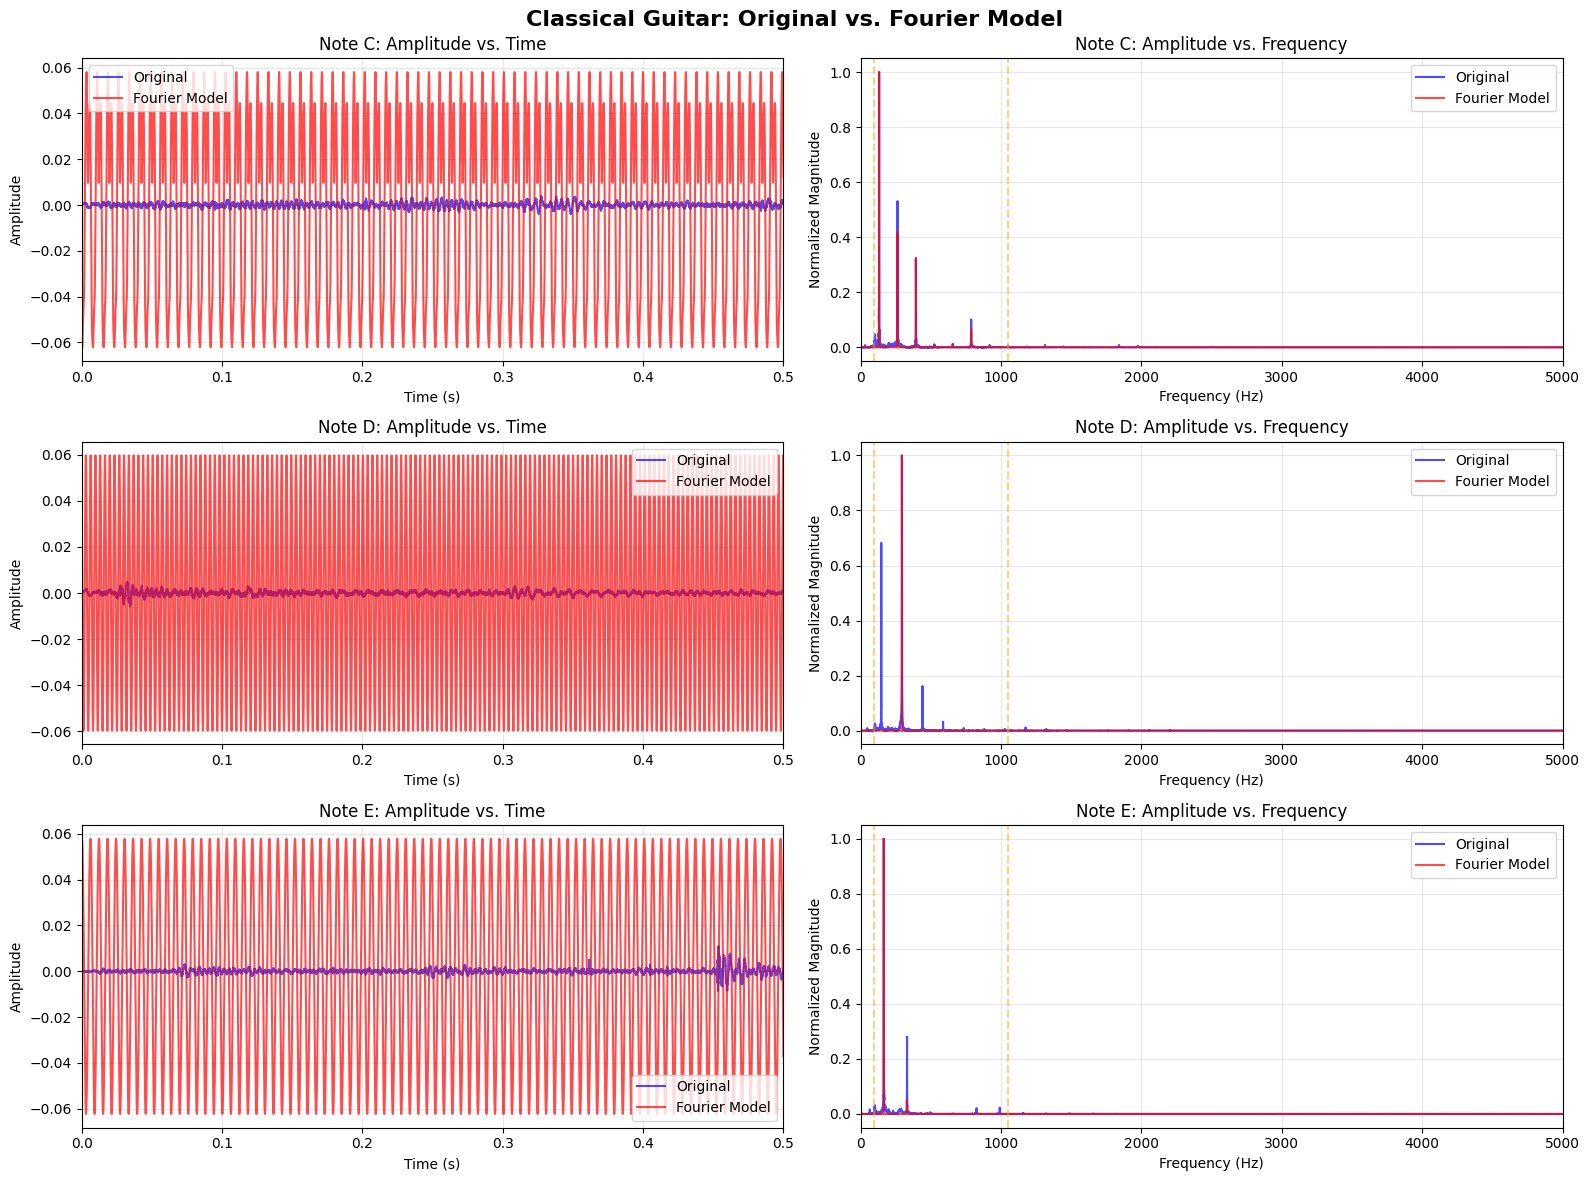

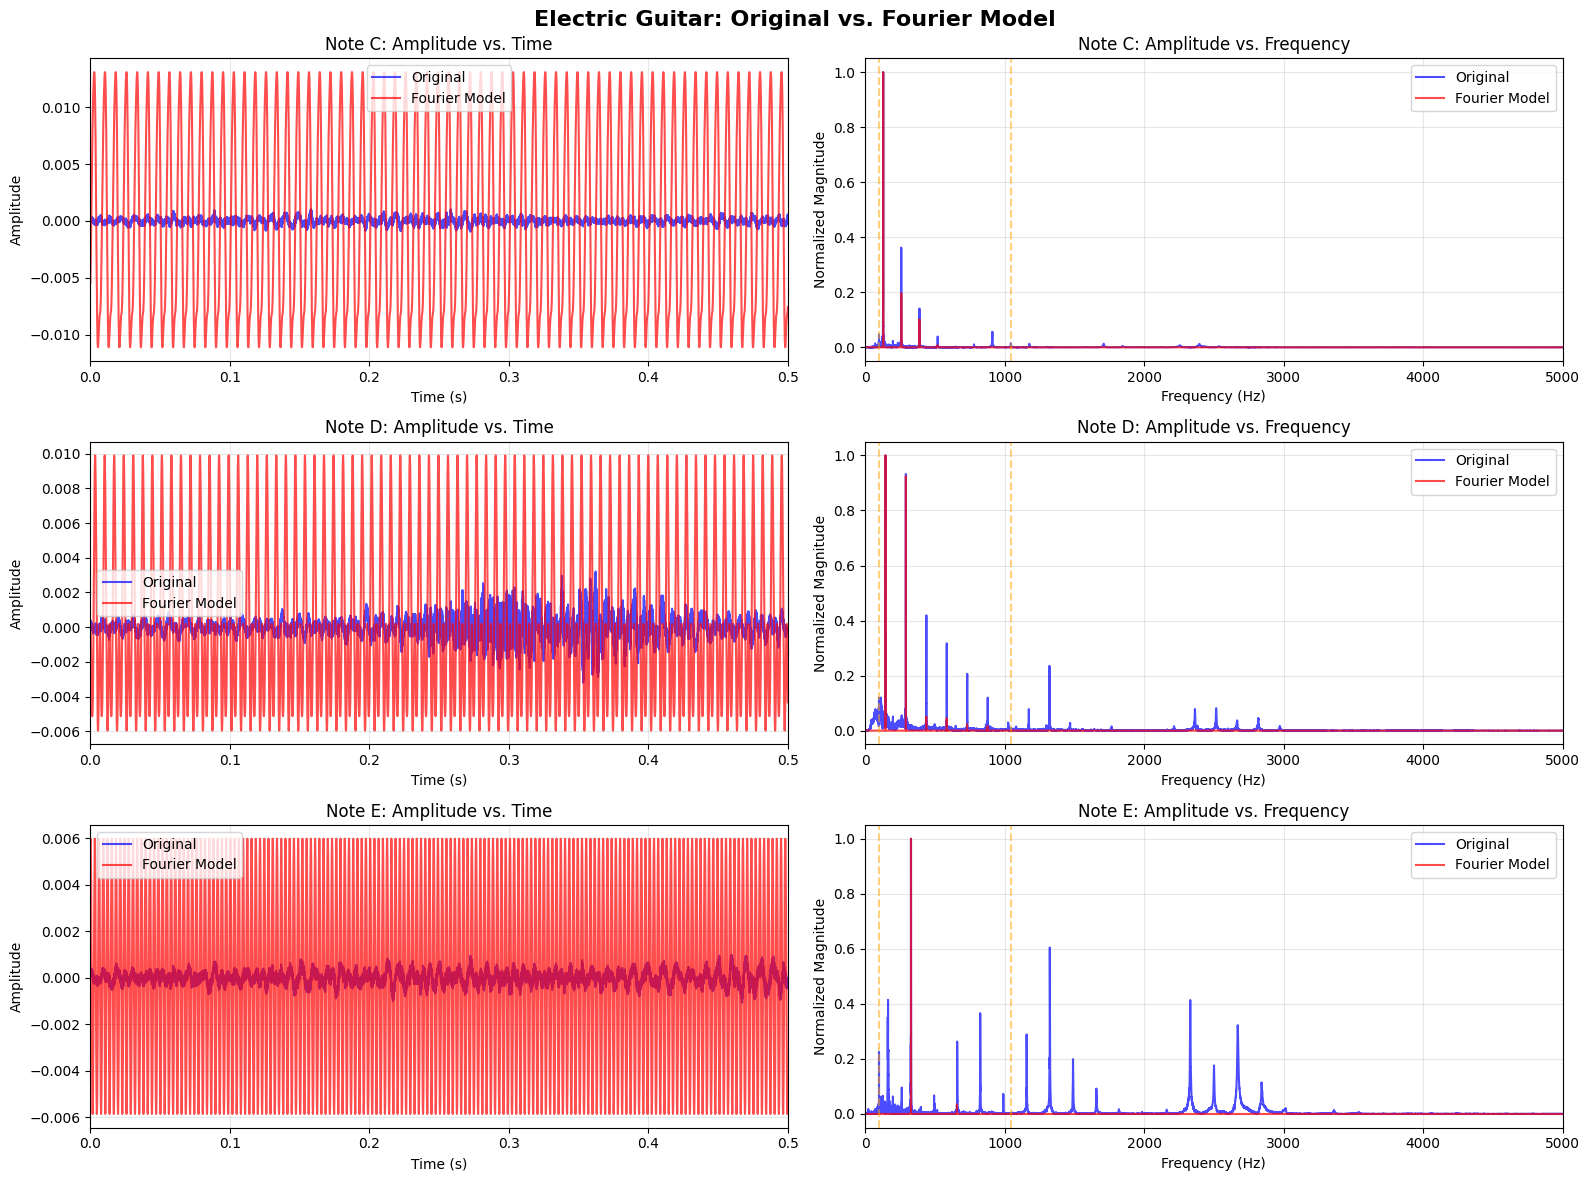

In [7]:
# Create overlay plots for each instrument/note combination
for instrument in INSTRUMENTS:
    fig, axes = plt.subplots(len(NOTES), 2, figsize=(16, 4 * len(NOTES)))
    fig.suptitle(f'{instrument.title()}: Original vs. Fourier Model', fontsize=16, fontweight='bold')
    
    for note_idx, note in enumerate(NOTES):
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        time = data['time']
        amp_orig = data['amplitude_original']
        amp_fourier = data['amplitude_fourier']
        sample_rate = data['sample_rate']
        
        # Compute FFT
        fft_orig = rfft(amp_orig)
        fft_fourier = rfft(amp_fourier)
        freqs = rfftfreq(len(amp_orig), 1/sample_rate)
        mag_orig = np.abs(fft_orig)
        mag_fourier = np.abs(fft_fourier)
        mag_orig_norm = mag_orig / np.max(mag_orig) if np.max(mag_orig) > 0 else mag_orig
        mag_fourier_norm = mag_fourier / np.max(mag_fourier) if np.max(mag_fourier) > 0 else mag_fourier
        
        t_window = min(0.5, time[-1])
        t_mask = time <= t_window
        freq_mask = freqs <= 5000
        
        # Time domain overlay
        ax = axes[note_idx, 0]
        ax.plot(time[t_mask], amp_orig[t_mask], 'b-', linewidth=1.5, label='Original', alpha=0.7)
        ax.plot(time[t_mask], amp_fourier[t_mask], 'r-', linewidth=1.5, label='Fourier Model', alpha=0.7)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Note {note}: Amplitude vs. Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, t_window])
        
        # Frequency domain overlay
        ax = axes[note_idx, 1]
        ax.plot(freqs[freq_mask], mag_orig_norm[freq_mask], 'b-', linewidth=1.5, label='Original', alpha=0.7)
        ax.plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, label='Fourier Model', alpha=0.7)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Normalized Magnitude')
        ax.set_title(f'Note {note}: Amplitude vs. Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 5000])
        ax.axvline(98, color='orange', linestyle='--', alpha=0.5, label='Sasando range')
        ax.axvline(1047, color='orange', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


## Summary Statistics


In [8]:
# Print summary table
print("\n" + "="*100)
print("SUMMARY: Fourier Model Matching Results")
print("="*100)
print(f"{'Instrument':<20} {'Note':<8} {'Fundamental (Hz)':<18} {'Max Ratio':<12} {'RMS Ratio':<12}")
print("-"*100)

for instrument in INSTRUMENTS:
    for note in NOTES:
        if results[instrument][note] is None:
            continue
            
        data = results[instrument][note]
        f0 = data['f0']
        amp_orig = data['amplitude_original']
        amp_fourier = data['amplitude_fourier']
        
        max_orig = np.max(np.abs(amp_orig))
        max_fourier = np.max(np.abs(amp_fourier))
        rms_orig = np.sqrt(np.mean(amp_orig**2))
        rms_fourier = np.sqrt(np.mean(amp_fourier**2))
        
        max_ratio = max_fourier / max_orig if max_orig > 0 else 0
        rms_ratio = rms_fourier / rms_orig if rms_orig > 0 else 0
        
        print(f"{instrument:<20} {note:<8} {f0:<18.2f} {max_ratio:<12.2f} {rms_ratio:<12.2f}")

print("="*100)
print("\nNote: Max Ratio and RMS Ratio show how well the Fourier model matches the original.")
print("  Ratio ≈ 1.0 means good match")
print("  Ratio < 1.0 means model is quieter")
print("  Ratio > 1.0 means model is louder")



SUMMARY: Fourier Model Matching Results
Instrument           Note     Fundamental (Hz)   Max Ratio    RMS Ratio   
----------------------------------------------------------------------------------------------------
acoustic guitar      C        262.63             0.12         1.00        
acoustic guitar      D        145.90             0.21         1.00        
acoustic guitar      E        163.96             0.20         1.00        
classical guitar     C        131.14             0.21         1.00        
classical guitar     D        293.85             0.15         1.00        
classical guitar     E        164.75             0.18         1.00        
electric guitar      C        129.89             0.18         1.00        
electric guitar      D        146.26             0.08         1.00        
electric guitar      E        329.29             0.05         1.00        

Note: Max Ratio and RMS Ratio show how well the Fourier model matches the original.
  Ratio ≈ 1.0 means goo